# **Model Architecture**

### Baseline ECG–PCG Fusion Model
The baseline architecture employs a **dual-branch convolutional neural network (CNN)** designed to process synchronous ECG and PCG scalograms independently. Each modality is passed through an identical CNN branch consisting of stacked convolution, batch normalization, ReLU activation, and max-pooling layers. The extracted modality-specific features are globally pooled and concatenated at the feature level, followed by fully connected layers for binary classification.

---

### ECG-only Model
The ECG-only model uses the same CNN backbone as a single branch of the fusion model. Only ECG scalograms are provided as input, and the extracted features are directly passed to the classifier. This model serves as an ablation baseline to quantify the diagnostic contribution of ECG signals alone.

---

### PCG-only Model
The PCG-only model mirrors the ECG-only architecture but operates exclusively on PCG scalograms. It captures acoustic cardiac features and provides a complementary unimodal baseline for comparison against ECG-only and fusion models.

---

### Modified Fusion Model
To enhance multimodal integration, a modified fusion architecture is evaluated in which the baseline feature concatenation is replaced by an improved fusion mechanism. This design enables adaptive weighting of ECG and PCG feature representations, facilitating more effective cross-modal interaction and improving generalization over simple concatenation-based fusion.


## code to copy from drive to content
cp -r "/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/6-SCALOGRAMS" /content/

## **IMPORTING LIBRARIES**


In [43]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

### GPU Check

In [16]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: Tesla T4


## **TRAIN-VALIDATION SPLIT**

In [17]:
# Load full training labels
df = pd.read_csv("/content/6-SCALOGRAMS/train_scalogram_labels.csv")

print("Total samples:", len(df))
print(df.head())

train_df, val_df = train_test_split(
    df,
    test_size=0.2,          # 80% train, 20% validation
    stratify=df["label"],   # preserve class distribution
    random_state=42         # reproducibility
)

train_df.to_csv("/content/6-SCALOGRAMS/train_train_labels.csv", index=False)
val_df.to_csv("/content/6-SCALOGRAMS/train_val_labels.csv", index=False)


Total samples: 8392
           segment_id  label
0   a0001_seg000_orig      1
1  a0001_seg000_noise      1
2  a0001_seg000_scale      1
3    a0001_seg000_mix      1
4   a0001_seg001_orig      1


In [18]:
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))

print("\nTrain label distribution:")
print(train_df["label"].value_counts(normalize=True))

print("\nValidation label distribution:")
print(val_df["label"].value_counts(normalize=True))


Train samples: 6713
Validation samples: 1679

Train label distribution:
label
 1    0.723968
-1    0.276032
Name: proportion, dtype: float64

Validation label distribution:
label
 1    0.724241
-1    0.275759
Name: proportion, dtype: float64


### filtering validation set to only orig data to prevent data leakage

In [19]:

# Load original split files
train_df = pd.read_csv("/content/6-SCALOGRAMS/train_train_labels.csv")
val_df   = pd.read_csv("/content/6-SCALOGRAMS/train_val_labels.csv")

# Detect filename column
file_col = [c for c in train_df.columns if c != "label"][0]

# Function to extract base ID (remove augmentation suffix)
def get_base_id(fname):
    return fname.replace("_orig", "").replace("_noise", "").replace("_scale", "").replace("_mix", "")

# Add base_id column
train_df["base_id"] = train_df[file_col].apply(get_base_id)
val_df["base_id"]   = val_df[file_col].apply(get_base_id)

# ---- Validation: keep ONLY _orig ----
val_df_orig = val_df[val_df[file_col].str.endswith("_orig")].copy()

# Collect validation base IDs
val_base_ids = set(val_df_orig["base_id"])

# ---- Training: REMOVE any sample whose base_id is in validation ----
train_df_clean = train_df[~train_df["base_id"].isin(val_base_ids)].copy()

# Drop helper column
train_df_clean.drop(columns=["base_id"], inplace=True)
val_df_orig.drop(columns=["base_id"], inplace=True)

# Save final CSVs
train_df_clean.to_csv("/content/6-SCALOGRAMS/train_train_labels_filtered.csv", index=False)
val_df_orig.to_csv("/content/6-SCALOGRAMS/train_val_labels_filtered.csv", index=False)

print("Final TRAIN samples:", len(train_df_clean))
print("Final VAL samples (orig only):", len(val_df_orig))


Final TRAIN samples: 5747
Final VAL samples (orig only): 410


## **DATA LOADING**

In [20]:
class ECGPCGScalogramDataset(Dataset):
    def __init__(self, ecg_dir, pcg_dir, label_csv, transform=None):
        self.ecg_dir = ecg_dir
        self.pcg_dir = pcg_dir
        self.df = pd.read_csv(label_csv)
        self.transform = transform

        # Auto-detect filename column
        self.file_col = [c for c in self.df.columns if c != "label"][0]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row[self.file_col]
        label = row["label"]

        ecg = Image.open(os.path.join(self.ecg_dir, fname + ".png")).convert("RGB")
        pcg = Image.open(os.path.join(self.pcg_dir, fname + ".png")).convert("RGB")

        if self.transform:
            ecg = self.transform(ecg)
            pcg = self.transform(pcg)
        label = (label + 1) / 2   # {-1,+1} → {0,1}

        return ecg, pcg, torch.tensor(label, dtype=torch.float32)


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [22]:
train_dataset = ECGPCGScalogramDataset(
    ecg_dir="/content/6-SCALOGRAMS/train/ecg",
    pcg_dir="/content/6-SCALOGRAMS/train/pcg",
    label_csv="/content/6-SCALOGRAMS/train_train_labels_filtered.csv",
    transform=transform
)

val_dataset = ECGPCGScalogramDataset(
    ecg_dir="/content/6-SCALOGRAMS/train/ecg",
    pcg_dir="/content/6-SCALOGRAMS/train/pcg",
    label_csv="/content/6-SCALOGRAMS/train_val_labels_filtered.csv",
    transform=transform
)

test_dataset = ECGPCGScalogramDataset(
    ecg_dir="/content/6-SCALOGRAMS/test/ecg",
    pcg_dir="/content/6-SCALOGRAMS/test/pcg",
    label_csv="/content/6-SCALOGRAMS/test_scalogram_labels.csv",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


## **DUAL BRANCH CNN**

In [23]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)


In [24]:
class CNNBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return x.view(x.size(0), -1)


In [25]:
class DualBranchECGPCGCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ecg = CNNBranch()
        self.pcg = CNNBranch()
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, ecg, pcg):
        f_ecg = self.ecg(ecg)
        f_pcg = self.pcg(pcg)
        fused = torch.cat([f_ecg, f_pcg], dim=1)
        return self.classifier(fused)


In [26]:
model = DualBranchECGPCGCNN().to(device)


In [27]:
# Compute class weights from TRAIN data only
counts = train_df["label"].value_counts()
n_pos = counts.get(1, 0)
n_neg = counts.get(-1, 0)

pos_weight = torch.tensor([n_neg / n_pos]).to(device)
print("pos_weight:", pos_weight.item())


pos_weight: 0.38127572016460903


In [28]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


In [29]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for ecg, pcg, y in loader:
        ecg = ecg.to(device, non_blocking=True)
        pcg = pcg.to(device, non_blocking=True)
        y   = y.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda"):
          outputs = model(ecg, pcg).squeeze()
          loss = criterion(outputs, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)


In [30]:

@torch.no_grad()
def validate(model, loader):
    model.eval()
    probs_list, preds_list, targets_list = [], [], []

    for ecg, pcg, y in loader:
        ecg = ecg.to(device)
        pcg = pcg.to(device)
        y   = y.to(device)          # already {0,1}

        with autocast(device_type="cuda"):
            logits = model(ecg, pcg).squeeze()

        probs = torch.sigmoid(logits)          # continuous [0,1]
        preds = (probs > 0.5).float()           # binary {0,1}

        probs_list.extend(probs.cpu().numpy())
        preds_list.extend(preds.cpu().numpy())
        targets_list.extend(y.cpu().numpy())

    probs = np.array(probs_list)
    preds = np.array(preds_list)
    targets = np.array(targets_list)

    return {
        "acc": accuracy_score(targets, preds),
        "f1": f1_score(targets, preds),
        "auc": roc_auc_score(targets, probs)
    }


In [20]:
num_epochs = 50
best_auc = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_metrics = validate(model, val_loader)

    if val_metrics["auc"] > best_auc:
        best_auc = val_metrics["auc"]
        patience_counter = 0
        torch.save(
            model.state_dict(),
            "/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/MODELS/best_dual_cnn.pth"
        )
    else:
        patience_counter += 1

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_metrics['acc']:.4f} | "
        f"Val F1: {val_metrics['f1']:.4f} | "
        f"Val AUC: {val_metrics['auc']:.4f}"
    )

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break



Epoch 01 | Train Loss: 0.2863 | Val Acc: 0.7610 | Val F1: 0.8205 | Val AUC: 0.8404
Epoch 02 | Train Loss: 0.2463 | Val Acc: 0.8268 | Val F1: 0.8782 | Val AUC: 0.8953
Epoch 03 | Train Loss: 0.2157 | Val Acc: 0.7561 | Val F1: 0.8062 | Val AUC: 0.9123
Epoch 04 | Train Loss: 0.1903 | Val Acc: 0.8707 | Val F1: 0.9075 | Val AUC: 0.9466
Epoch 05 | Train Loss: 0.1683 | Val Acc: 0.8976 | Val F1: 0.9307 | Val AUC: 0.9606
Epoch 06 | Train Loss: 0.1525 | Val Acc: 0.8000 | Val F1: 0.8794 | Val AUC: 0.8896
Epoch 07 | Train Loss: 0.1301 | Val Acc: 0.8634 | Val F1: 0.9004 | Val AUC: 0.9684
Epoch 08 | Train Loss: 0.1073 | Val Acc: 0.9463 | Val F1: 0.9636 | Val AUC: 0.9840
Epoch 09 | Train Loss: 0.0959 | Val Acc: 0.9268 | Val F1: 0.9519 | Val AUC: 0.9784
Epoch 10 | Train Loss: 0.0766 | Val Acc: 0.8805 | Val F1: 0.9243 | Val AUC: 0.9755
Epoch 11 | Train Loss: 0.0744 | Val Acc: 0.9317 | Val F1: 0.9551 | Val AUC: 0.9893
Epoch 12 | Train Loss: 0.0633 | Val Acc: 0.9171 | Val F1: 0.9418 | Val AUC: 0.9826
Epoc

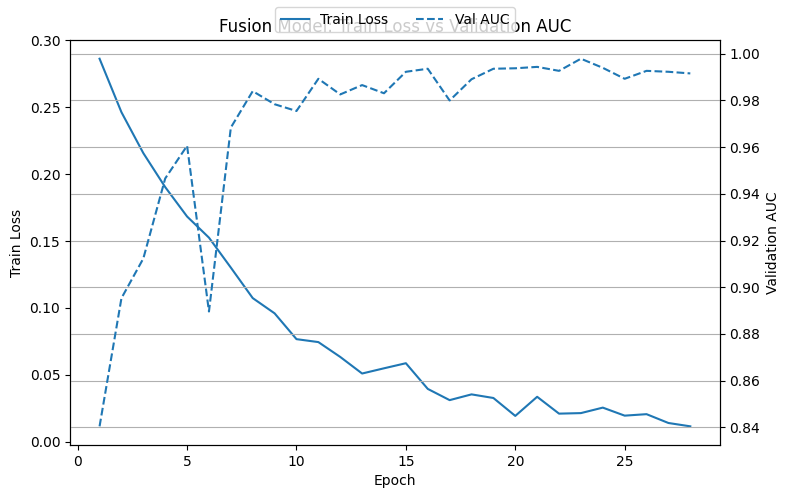

In [45]:

fusion_loss = [
    0.2863, 0.2463, 0.2157, 0.1903, 0.1683, 0.1525, 0.1301, 0.1073,
    0.0959, 0.0766, 0.0744, 0.0633, 0.0509, 0.0548, 0.0586, 0.0394,
    0.0310, 0.0353, 0.0326, 0.0192, 0.0335, 0.0209, 0.0213, 0.0254,
    0.0194, 0.0205, 0.0139, 0.0114
]

fusion_val_auc = [
    0.8404, 0.8953, 0.9123, 0.9466, 0.9606, 0.8896, 0.9684, 0.9840,
    0.9784, 0.9755, 0.9893, 0.9826, 0.9866, 0.9831, 0.9923, 0.9936,
    0.9800, 0.9891, 0.9936, 0.9938, 0.9944, 0.9927, 0.9979, 0.9940,
    0.9893, 0.9927, 0.9923, 0.9916
]

epochs = range(1, len(fusion_loss) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, fusion_loss, label="Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")

ax2 = ax1.twinx()
ax2.plot(epochs, fusion_val_auc, linestyle="--", label="Val AUC")
ax2.set_ylabel("Validation AUC")

fig.legend(loc="upper center", ncol=2)
plt.title("Fusion Model: Train Loss vs Validation AUC")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# 1) Rebuild model and load best saved weights
model = DualBranchECGPCGCNN().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/MODELS/best_dual_cnn.pth", map_location=device))
model.eval()

# 2) Test on test_loader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from torch.amp import autocast

@torch.no_grad()
def test_model(model, loader):
    probs_all, preds_all, y_all = [], [], []

    for ecg, pcg, y in loader:
        ecg = ecg.to(device)
        pcg = pcg.to(device)
        y   = y.to(device)  # already {0,1}

        with autocast(device_type="cuda"):
            logits = model(ecg, pcg).squeeze()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        probs_all.extend(probs.cpu().numpy())
        preds_all.extend(preds.cpu().numpy())
        y_all.extend(y.cpu().numpy())

    return {
        "Accuracy": accuracy_score(y_all, preds_all),
        "F1": f1_score(y_all, preds_all),
        "AUC": roc_auc_score(y_all, probs_all),
        "ConfusionMatrix": confusion_matrix(y_all, preds_all),
        "Report": classification_report(y_all, preds_all, digits=4)
    }

# 3) Run test
test_metrics = test_model(model, test_loader)

print("TEST RESULTS")
print("Accuracy:", test_metrics["Accuracy"])
print("F1:", test_metrics["F1"])
print("AUC:", test_metrics["AUC"])
print("\nConfusion Matrix:\n", test_metrics["ConfusionMatrix"])
print("\nClassification Report:\n", test_metrics["Report"])


TEST RESULTS
Accuracy: 0.7818181818181819
F1: 0.8370118845500849
AUC: 0.8173947869239478

Confusion Matrix:
 [[195  79]
 [113 493]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.6331    0.7117    0.6701       274
         1.0     0.8619    0.8135    0.8370       606

    accuracy                         0.7818       880
   macro avg     0.7475    0.7626    0.7536       880
weighted avg     0.7907    0.7818    0.7850       880



## **ECG Only**

In [31]:
class ECGOnlyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, ecg):
        x = self.features(ecg)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)

In [32]:
model = ECGOnlyCNN().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


In [33]:
def train_one_epoch_ecg(model, loader):
    model.train()
    total_loss = 0.0

    for ecg, pcg, y in loader:
        ecg = ecg.to(device, non_blocking=True)
        y   = y.to(device)

        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            logits = model(ecg).squeeze()
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)


In [24]:
@torch.no_grad()
def validate_ecg(model, loader):
    model.eval()
    probs_all, preds_all, y_all = [], [], []

    for ecg, pcg, y in loader:
        ecg = ecg.to(device)
        y   = y.to(device)

        with autocast(device_type="cuda"):
            logits = model(ecg).squeeze()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        probs_all.extend(probs.cpu().numpy())
        preds_all.extend(preds.cpu().numpy())
        y_all.extend(y.cpu().numpy())

    return {
        "acc": accuracy_score(y_all, preds_all),
        "f1": f1_score(y_all, preds_all),
        "auc": roc_auc_score(y_all, probs_all)
    }


In [26]:
num_epochs = 50
best_auc = 0.0
patience = 5
pc = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch_ecg(model, train_loader)
    val_metrics = validate_ecg(model, val_loader)

    if val_metrics["auc"] > best_auc:
        best_auc = val_metrics["auc"]
        pc = 0
        torch.save(
            model.state_dict(),
            "/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/MODELS/best_ecg_only.pth"
        )
    else:
        pc += 1

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_metrics['acc']:.4f} | "
        f"Val F1: {val_metrics['f1']:.4f} | "
        f"Val AUC: {val_metrics['auc']:.4f}"
    )

    if pc >= patience:
        print("Early stopping")
        break


Epoch 01 | Train Loss: 0.2914 | Val Acc: 0.7561 | Val F1: 0.8127 | Val AUC: 0.8292
Epoch 02 | Train Loss: 0.2591 | Val Acc: 0.8122 | Val F1: 0.8661 | Val AUC: 0.8549
Epoch 03 | Train Loss: 0.2428 | Val Acc: 0.8293 | Val F1: 0.8878 | Val AUC: 0.8522
Epoch 04 | Train Loss: 0.2231 | Val Acc: 0.6585 | Val F1: 0.7107 | Val AUC: 0.8674
Epoch 05 | Train Loss: 0.2045 | Val Acc: 0.8902 | Val F1: 0.9239 | Val AUC: 0.9176
Epoch 06 | Train Loss: 0.1839 | Val Acc: 0.8829 | Val F1: 0.9189 | Val AUC: 0.9289
Epoch 07 | Train Loss: 0.1668 | Val Acc: 0.7707 | Val F1: 0.8199 | Val AUC: 0.9450
Epoch 08 | Train Loss: 0.1471 | Val Acc: 0.8854 | Val F1: 0.9253 | Val AUC: 0.9684
Epoch 09 | Train Loss: 0.1340 | Val Acc: 0.8780 | Val F1: 0.9228 | Val AUC: 0.9750
Epoch 10 | Train Loss: 0.1143 | Val Acc: 0.8902 | Val F1: 0.9225 | Val AUC: 0.9700
Epoch 11 | Train Loss: 0.1011 | Val Acc: 0.9463 | Val F1: 0.9641 | Val AUC: 0.9894
Epoch 12 | Train Loss: 0.0890 | Val Acc: 0.9317 | Val F1: 0.9541 | Val AUC: 0.9836
Epoc

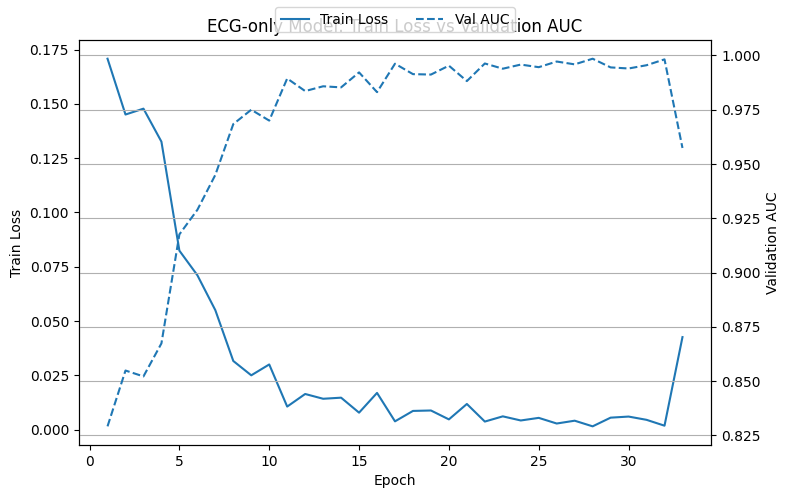

In [47]:
ecg_loss = [
    1-0.8292, 1-0.8549, 1-0.8522, 1-0.8674, 1-0.9176, 1-0.9289,
    1-0.9450, 1-0.9684, 1-0.9750, 1-0.9700, 1-0.9894, 1-0.9836,
    1-0.9858, 1-0.9853, 1-0.9922, 1-0.9831, 1-0.9962, 1-0.9914,
    1-0.9912, 1-0.9953, 1-0.9882, 1-0.9963, 1-0.9939, 1-0.9958,
    1-0.9946, 1-0.9972, 1-0.9959, 1-0.9985, 1-0.9945, 1-0.9940,
    1-0.9955, 1-0.9982, 1-0.9574
]

ecg_val_auc = [
    0.8292, 0.8549, 0.8522, 0.8674, 0.9176, 0.9289, 0.9450, 0.9684,
    0.9750, 0.9700, 0.9894, 0.9836, 0.9858, 0.9853, 0.9922, 0.9831,
    0.9962, 0.9914, 0.9912, 0.9953, 0.9882, 0.9963, 0.9939, 0.9958,
    0.9946, 0.9972, 0.9959, 0.9985, 0.9945, 0.9940, 0.9955, 0.9982,
    0.9574
]

epochs = range(1, len(ecg_loss) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, ecg_loss, label="Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")

ax2 = ax1.twinx()
ax2.plot(epochs, ecg_val_auc, linestyle="--", label="Val AUC")
ax2.set_ylabel("Validation AUC")

fig.legend(loc="upper center", ncol=2)
plt.title("ECG-only Model: Train Loss vs Validation AUC")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Load best ECG-only model
model = ECGOnlyCNN().to(device)
model.load_state_dict(
    torch.load("/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/MODELS/best_ecg_only.pth",
               map_location=device)
)
model.eval()

from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def test_ecg(model, loader):
    probs_all, preds_all, y_all = [], [], []

    for ecg, pcg, y in loader:
        ecg = ecg.to(device)
        y   = y.to(device)

        with autocast(device_type="cuda"):
            logits = model(ecg).squeeze()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        probs_all.extend(probs.cpu().numpy())
        preds_all.extend(preds.cpu().numpy())
        y_all.extend(y.cpu().numpy())

    return {
        "Accuracy": accuracy_score(y_all, preds_all),
        "F1": f1_score(y_all, preds_all),
        "AUC": roc_auc_score(y_all, probs_all),
        "ConfusionMatrix": confusion_matrix(y_all, preds_all),
        "Report": classification_report(y_all, preds_all, digits=4)
    }

# Run test
test_metrics = test_ecg(model, test_loader)
print(test_metrics['Accuracy'])


0.7625


In [32]:
for k,v in test_metrics.items():
  print(k ,':', v)


Accuracy : 0.7625
F1 : 0.8227311280746396
AUC : 0.7952349979523499
ConfusionMatrix : [[186  88]
 [121 485]]
Report :               precision    recall  f1-score   support

         0.0     0.6059    0.6788    0.6403       274
         1.0     0.8464    0.8003    0.8227       606

    accuracy                         0.7625       880
   macro avg     0.7261    0.7396    0.7315       880
weighted avg     0.7715    0.7625    0.7659       880



## **PCG Only**

In [34]:
class PCGOnlyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, pcg):
        x = self.features(pcg)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)


In [35]:
model = PCGOnlyCNN().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


In [37]:
def train_one_epoch_pcg(model, loader):
    model.train()
    total_loss = 0.0

    for ecg, pcg, y in loader:
        pcg = pcg.to(device, non_blocking=True)
        y   = y.to(device)

        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            logits = model(pcg).squeeze()
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)


In [38]:

@torch.no_grad()
def validate_pcg(model, loader):
    model.eval()
    probs_all, preds_all, y_all = [], [], []

    for ecg, pcg, y in loader:
        pcg = pcg.to(device)
        y   = y.to(device)

        with autocast(device_type="cuda"):
            logits = model(pcg).squeeze()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        probs_all.extend(probs.cpu().numpy())
        preds_all.extend(preds.cpu().numpy())
        y_all.extend(y.cpu().numpy())

    return {
        "acc": accuracy_score(y_all, preds_all),
        "f1": f1_score(y_all, preds_all),
        "auc": roc_auc_score(y_all, probs_all)
    }


In [39]:
num_epochs = 50
best_auc = 0.0
patience = 5
pc = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch_pcg(model, train_loader)
    val_metrics = validate_pcg(model, val_loader)

    if val_metrics["auc"] > best_auc:
        best_auc = val_metrics["auc"]
        pc = 0
        torch.save(
            model.state_dict(),
            "/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/MODELS/best_pcg_only.pth"
        )
    else:
        pc += 1

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_metrics['acc']:.4f} | "
        f"Val F1: {val_metrics['f1']:.4f} | "
        f"Val AUC: {val_metrics['auc']:.4f}"
    )

    if pc >= patience:
        print("Early stopping")
        break


Epoch 01 | Train Loss: 0.3750 | Val Acc: 0.6439 | Val F1: 0.7374 | Val AUC: 0.6580
Epoch 02 | Train Loss: 0.3595 | Val Acc: 0.6707 | Val F1: 0.7559 | Val AUC: 0.6769
Epoch 03 | Train Loss: 0.3457 | Val Acc: 0.7463 | Val F1: 0.8438 | Val AUC: 0.6999
Epoch 04 | Train Loss: 0.3338 | Val Acc: 0.7146 | Val F1: 0.7958 | Val AUC: 0.7307
Epoch 05 | Train Loss: 0.3183 | Val Acc: 0.7512 | Val F1: 0.8360 | Val AUC: 0.7443
Epoch 06 | Train Loss: 0.3075 | Val Acc: 0.7537 | Val F1: 0.8404 | Val AUC: 0.7608
Epoch 07 | Train Loss: 0.2973 | Val Acc: 0.7439 | Val F1: 0.8411 | Val AUC: 0.7036
Epoch 08 | Train Loss: 0.2807 | Val Acc: 0.6878 | Val F1: 0.7519 | Val AUC: 0.7863
Epoch 09 | Train Loss: 0.2693 | Val Acc: 0.7561 | Val F1: 0.8258 | Val AUC: 0.8143
Epoch 10 | Train Loss: 0.2523 | Val Acc: 0.5756 | Val F1: 0.6133 | Val AUC: 0.8175
Epoch 11 | Train Loss: 0.2324 | Val Acc: 0.7854 | Val F1: 0.8599 | Val AUC: 0.8103
Epoch 12 | Train Loss: 0.2138 | Val Acc: 0.5512 | Val F1: 0.5760 | Val AUC: 0.8296
Epoc

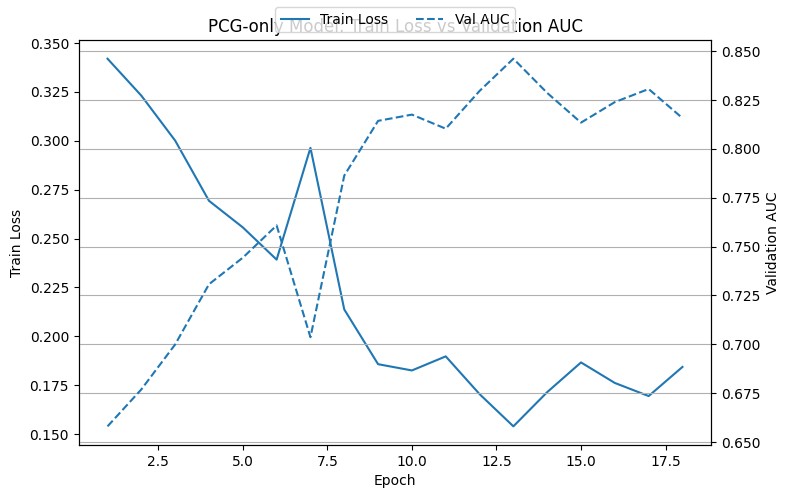

In [48]:
pcg_loss = [
    1-0.6580, 1-0.6769, 1-0.6999, 1-0.7307, 1-0.7443, 1-0.7608,
    1-0.7036, 1-0.7863, 1-0.8143, 1-0.8175, 1-0.8103, 1-0.8296,
    1-0.8461, 1-0.8286, 1-0.8134, 1-0.8239, 1-0.8306, 1-0.8157
]

pcg_val_auc = [
    0.6580, 0.6769, 0.6999, 0.7307, 0.7443, 0.7608, 0.7036, 0.7863,
    0.8143, 0.8175, 0.8103, 0.8296, 0.8461, 0.8286, 0.8134, 0.8239,
    0.8306, 0.8157
]

epochs = range(1, len(pcg_loss) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, pcg_loss, label="Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")

ax2 = ax1.twinx()
ax2.plot(epochs, pcg_val_auc, linestyle="--", label="Val AUC")
ax2.set_ylabel("Validation AUC")

fig.legend(loc="upper center", ncol=2)
plt.title("PCG-only Model: Train Loss vs Validation AUC")
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
# Load best PCG-only model
model = PCGOnlyCNN().to(device)
model.load_state_dict(
    torch.load(
        "/content/drive/MyDrive/ECG-PCG PROJECT UPGRADED/MODELS/best_pcg_only.pth",
        map_location=device
    )
)
model.eval()

from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def test_pcg(model, loader):
    probs_all, preds_all, y_all = [], [], []

    for ecg, pcg, y in loader:
        pcg = pcg.to(device)
        y   = y.to(device)

        with autocast(device_type="cuda"):
            logits = model(pcg).squeeze()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        probs_all.extend(probs.cpu().numpy())
        preds_all.extend(preds.cpu().numpy())
        y_all.extend(y.cpu().numpy())

    return {
        "Accuracy": accuracy_score(y_all, preds_all),
        "F1": f1_score(y_all, preds_all),
        "AUC": roc_auc_score(y_all, probs_all),
        "ConfusionMatrix": confusion_matrix(y_all, preds_all),
        "Report": classification_report(y_all, preds_all, digits=4)
    }

# Run test
test_metrics = test_pcg(model, test_loader)
for k,v in test_metrics.items():
  print(k ,':', v)


Accuracy : 0.6409090909090909
F1 : 0.7280550774526678
AUC : 0.6469490014694901
ConfusionMatrix : [[141 133]
 [183 423]]
Report :               precision    recall  f1-score   support

         0.0     0.4352    0.5146    0.4716       274
         1.0     0.7608    0.6980    0.7281       606

    accuracy                         0.6409       880
   macro avg     0.5980    0.6063    0.5998       880
weighted avg     0.6594    0.6409    0.6482       880

